In [2]:
import pandas as pd
import numpy as np


In [3]:
train = pd.read_csv(r"E:\Test trail\Data\CommnLit Readability prize Assignment 6\train.csv")
test = pd.read_csv(r"E:\Test trail\Data\CommnLit Readability prize Assignment 6\test.csv")

In [4]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [5]:
test.head()

,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


In [8]:
cols = ['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error']
for col in cols:
    print(col,':',train[col].nunique())

id : 2834
url_legal : 667
license : 15
excerpt : 2834
target : 2834
standard_error : 2834


<AxesSubplot: >

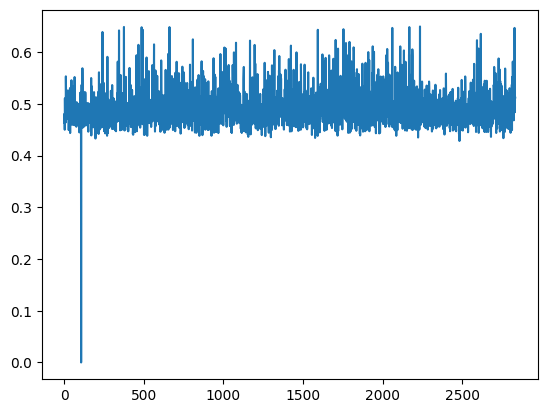

In [9]:
train.standard_error.plot()

In [10]:
#Data preparation

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

def lemmatize_text_words(words):
    lemmatizer = WordNetLemmatizer()
    
    lemmatized_words = list()
    
    for word in words:
        pos = pos_tag(word)
        
        if pos[0] == 'V':
            pos = wordnet.VERB
        elif pos[0] == 'J':
            pos = wordnet.ADJ
        elif pos[0] == 'R':
            pos = wordnet.ADV
        else:
            pos = wordnet.NOUN
    
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
        
    return lemmatized_words

In [11]:
def count_punctuation(words, punct_string='!?.,:'):
    counts = dict.fromkeys(punct_string, 0)
    for word in words:
        if word in punct_string:
            counts[word] += 1
    return counts

In [12]:
def remove_punctuation(words, punct_string='!?.,:'):
    for word in words:
        if word in punct_string:
            words.remove(word)
    return words

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def make_dictionary(texts):
    words = ' '.join(texts)
    words_dict = set(word_tokenize(words))
    return remove_punctuation(list(words_dict))
    

def prepare_texts(texts, punct_string='!?.,:'):
    stop_words = set(stopwords.words('english'))
    
    prepared_texts = list()
    punctuation_counts = pd.DataFrame(columns=list(punct_string))
    
    for i, text in enumerate(texts):
        text = word_tokenize(text.lower())
        text = [word for word in text if word not in stop_words]
        text = lemmatize_text_words(text)
        punctuation_counts = punctuation_counts.append(pd.Series(count_punctuation(text, punct_string=punct_string)), ignore_index=True)
        text = remove_punctuation(text)
        prepared_texts.append(' '.join(text))
        
    return prepared_texts, punctuation_counts

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=1)

prepared_texts, punctuation_counts = prepare_texts(train.excerpt.copy(deep=True))


train_tfidf = vectorizer.fit_transform(prepared_texts)

TypeError: tokens: expected a list of strings, got a string

In [ ]:
train_with_punctuation = pd.DataFrame(train_tfidf.toarray()).join(punctuation_counts)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import math

math.sqrt(-np.mean(cross_val_score(GradientBoostingRegressor(), X=train_tfidf, y=train.target, scoring='neg_mean_squared_error', n_jobs=-1, verbose=5, cv=4)))

In [ ]:
math.sqrt(-np.mean(cross_val_score(GradientBoostingRegressor(), X=train_with_punctuation, y=train.target, scoring='neg_mean_squared_error', n_jobs=-1, verbose=5, cv=4)))

In [ ]:
prepared_test, test_punctuation = prepare_texts(test.excerpt.copy(deep=True))

test_tfidf = vectorizer.transform(prepared_test)
test_with_punctuation = pd.DataFrame(test_tfidf.toarray()).join(test_punctuation)

In [ ]:
model = GradientBoostingRegressor()
model.fit(train_with_punctuation, train.target)

In [ ]:
GradientBoostingRegressor()

In [ ]:
predicted = model.predict(test_with_punctuation)

In [ ]:
submission = pd.DataFrame(data={'id': test.id, 'target': predicted})

In [ ]:
submission.to_csv(r'E:\Test trail\Data\CommnLit Readability prize Assignment 6\sample_submission.csv', index=False)